# SIR modelling - finding age group parameters

## Install packages

In [8]:
# https://www.twilio.com/blog/2017/02/an-easy-way-to-read-and-write-to-a-google-spreadsheet-in-python.html
# Created by Jeremy Cruz - https://code.sololearn.com/c4gmt97Se5f9/?ref=app

import subprocess
import sys

def install(package):
    subprocess.call([
        sys.executable, "-m", "pip", "-q", "install", package
    ])

install('gspread')
install('oauth2client')

## Define global helper functions

In [9]:
titles = [
    'Whole population',
    '0 - 9',
    '10 - 19',
    '20 - 29',
    '30 - 39',
    '40 - 49',
    '50 - 59',
    '60 - 69',
    '70 - 79',
    '80 - 89',
    '90+'
]

def convert_to_int(list):
    return [int(item) for item in list]

def get_age_group_title(age_group_index):
    return titles[age_group_index]
    

## Graph parameters for all age groups

Enter how many days to capture for one interval: 15


<IPython.core.display.Javascript object>


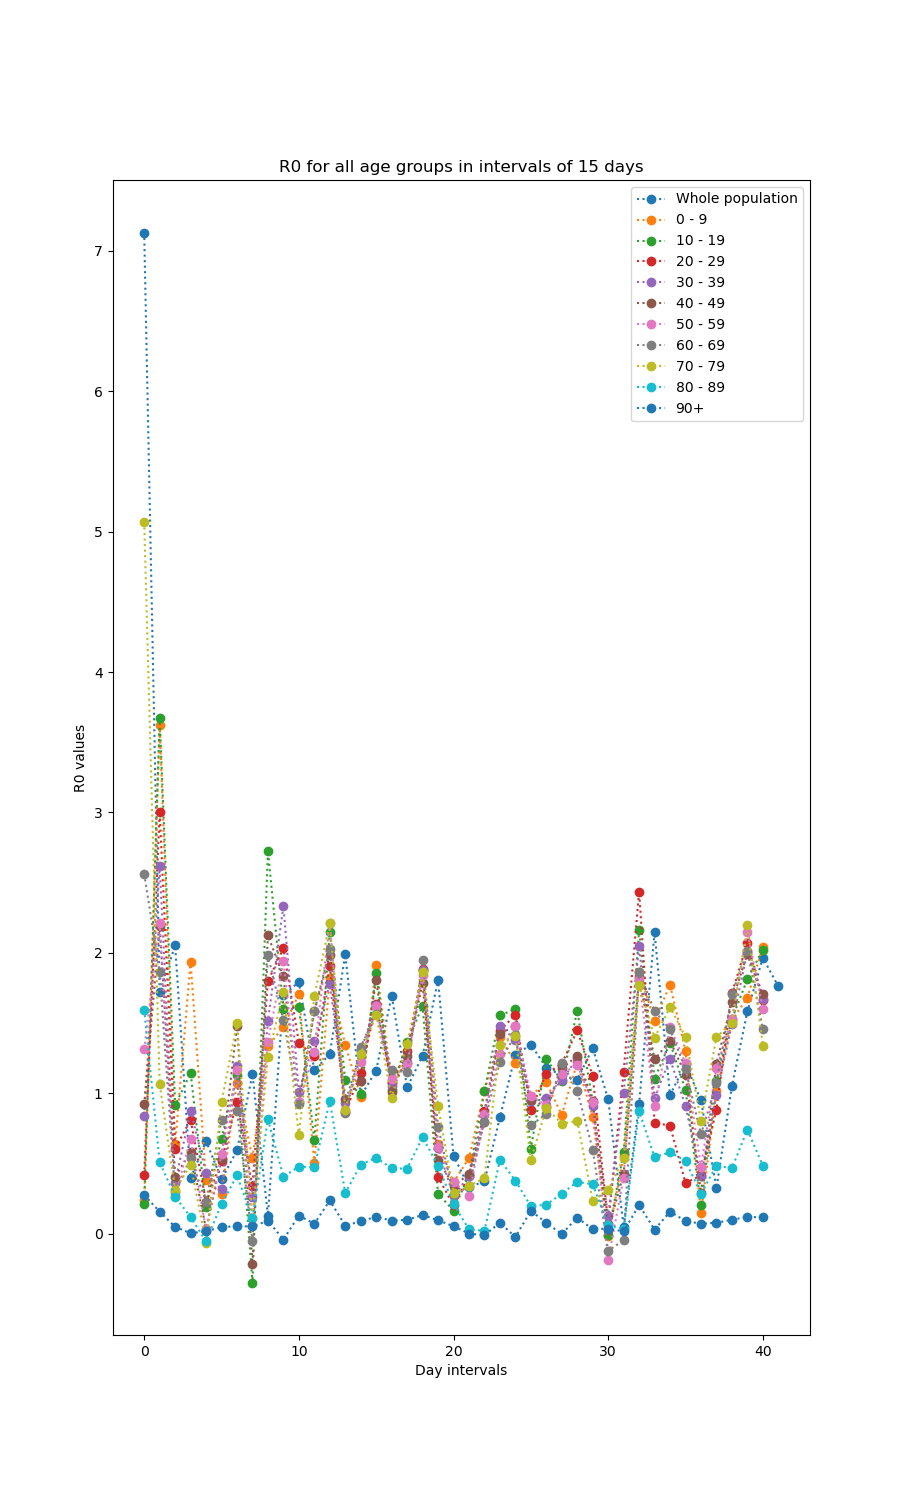

In [11]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/spreadsheets',
         'https://www.googleapis.com/auth/drive.file','https://www.googleapis.com/auth/drive']

creds = ServiceAccountCredentials.from_json_keyfile_name('client_secret.json', scope)

client = gspread.authorize(creds)

import os
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

interval_length = int(input('Enter how many days to capture for one interval: '))      # Default: 14

plt.figure(figsize = (9, 15))

plt.title('R0 for all age groups in intervals of ' + str(interval_length) + ' days')

for age_group_index in range(11):
    sheet = client.open('Denmark Covid-19 Data').get_worksheet(age_group_index)
    
    # Modify excel data
    date_full_column = sheet.col_values(1)   # Column A
    s_full_column = sheet.col_values(2)      # Column B
    i_full_column = sheet.col_values(3)      # Column C
    r_full_column = sheet.col_values(4)      # Column D

    # Remove first line of each column
    date_full_column.pop(0)
    s_full_column.pop(0)
    i_full_column.pop(0)
    r_full_column.pop(0)

    n = int(s_full_column[0]) + int(i_full_column[0]) + int(r_full_column[0])
    
    # Finding beta
    interval_count = math.ceil(len(date_full_column) / interval_length)

    r0_list = []

    for interval_index in range(interval_count):
        interval_start_index = interval_index * interval_length
        interval_end_index =  interval_start_index + interval_length

        interval_date_column = date_full_column[interval_start_index : interval_end_index]
        interval_s_column = convert_to_int(s_full_column[interval_start_index : interval_end_index])
        interval_i_column = convert_to_int(i_full_column[interval_start_index : interval_end_index])
        interval_r_column = convert_to_int(r_full_column[interval_start_index : interval_end_index])

        real_interval_length = len(interval_date_column)

        if (real_interval_length > 1 and interval_i_column[0] != 0):
            interval_x = np.array(range(real_interval_length))
            interval_y = np.log(interval_i_column)

            p = np.polyfit(interval_x, interval_y, 1)

            m = p[0]  # Slope
            b = p[1]  # Intersection at x = 0

            alfa = 1 / 14# (interval_r_column[-1] - interval_r_column[0]) / ((real_interval_length - 1) * interval_i_column[0])

            interval_s_average = sum(interval_s_column) / len(interval_s_column)

            beta = (n / interval_s_average) * (alfa + m)

            r0_list.append(beta / alfa)

    x = np.array(range(len(r0_list)))

    plt.plot(x, r0_list, ':o', label = get_age_group_title(age_group_index))

plt.legend()

plt.xlabel('Day intervals')
plt.ylabel('R0 values')

if not os.path.exists('./Images'):
    os.makedirs('./Images')

plt.savefig('./Images/r0_params.png')
plt.show()